# Assignment: DSC 360 (Big Data Analytics) Final Project

## Author: Eric Caldwell

### Date Finished: 12/14/2023

### Data Source: https://www.kaggle.com/datasets/sherrytp/airline-delay-analysis

* The dataset I am analyzing was taken from Kaggle and contains information about airport flights around the world in 2010.

* The dataset has 6,450,117 rows and 27 (usable) columns.

* I would like to investigate the causes of "underperforming" airline carriers. For example, what is causing certain airline carriers to have longer delay times than others? What are the main causes? If certain carriers consistently perform worse than others across multiple categories, maybe there are issues that need to be addressed from a business operations standpoint. On the contrary, maybe there are external factors (political/geographic/weather) that are limiting the capacity of the airline? The airline operations manager will not have the answer unless some big data analysis is performed. 

__Techniques from textbook:__ 

* Plotting in Plotly, Seaborn, and Pandas

* Bar Charts, Scatter Plots, Box and Whisker Plots, Heatmaps

* Analysis in Both PySpark and Pandas

* Aggregation Techniques

* Masking/Filtering

* EDA

* Correlations

## Most Important Takeaway: 

* __Carrier Delays (inside the airline's control) are a major source of lost productivity.__

# Table of Contents

* [PySpark Data Intro](#PySpark-Data-Intro)

* [Airline Arrival Times](#airline_arrival_times)

* [Cause of Delays](#cause_of_delays)

* [Graphs and Analysis](#graphs_and_analysis)

* [Results and Conclusions](#results_and_conclusions)

In [2]:
# Import Cell
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
import findspark
import pyspark
from ydata_profiling import ProfileReport
import collections 
import random
from scipy import stats
from sklearn import preprocessing
import time
import re
import os
import sklearn as sk
import ipywidgets as widgets
from pyspark.sql.functions import isnan, when, count, col, mean
from pyspark.sql.functions import monotonically_increasing_id
import plotly as py
import plotly.graph_objs as go
from  chart_studio.plotly import iplot
from plotly import __version__
import chart_studio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
sns.set(style="ticks")

In [3]:
# Begin a plotly notebook
init_notebook_mode(connected=True)
# (It's a surprise tool that will help us later)

In [4]:
# Load bearing line of code
findspark.init()

In [5]:
# Set the file path
path=r"C:\Users\13309\OneDrive - University of Mount Union\Python Progams\DSC 360\DSC 360 Final Project\airline delay analysis\2010.csv"

# PySpark Data Intro <a class="anchor" id="PySpark-Data-Intro"></a>

In [6]:
# Build the Spark Session
spark=SparkSession.builder.appName('2010').getOrCreate()

In [7]:
# Read in the CSV data
df_csv=spark.read.csv(path, header=True, inferSchema=True)

# Data Dictionary

### Provides Detailed attribute level info

##### Note: The data types in the cell below this one may not exactly agree (i.e. say double when it should not).
##### This is because there are NaN values still in the dataset at this point.


FL_DATE - Flight Date (Date)

OP_CARRIER - Carrier Company (string)(categorical: MQ, OH, OO, UA, US, WN, XE, YV, DL, EV, F9, FL, HA, 9E, AA, AS, B6, CO)

OP_CARRIER_FL_NUM - Flight Number (integer)

ORIGIN - Origin (string) (LGA, DCA, RDU, JFK, BOS, CMH, CLE, BDL, XNA, DTW, BNA, GSO, MEM, SDF, OMA, PIT, ORF, BGR, MDW, DAY, among others) (same for DEST)

DEST - Destination (string)

CRS_DEP_TIME - Carrier's Scheduled Departure time (integer) (written as ####  but really means ##:## format)

DEP_TIME - Actual Departure time (integer)

DEP_DELAY - The departure delay time. The difference between the two above features. Negative when flight leaves early and positive when flight is late. (integer)

TAXI_OUT - Time for takeoff runway taxiing (integer)

WHEELS_OFF - Takeoff Time (integer) (#### -> ##:##)

WHEELS_ON - Landing Time (integer) (#### -> ##:##)

TAXI_IN - Time for landing runway taxiing (#### -> ##:##)

CRS_ARR_TIME - Carrier's Scheduled Arrival Time (integer) (#### -> ##:##)

ARR_TIME - Actual Arrival Time (#### -> ##:##)

ARR_DELAY - Arrival Delay Time. Difference between the above two features. Negative when flight arrives early and positive when flight is late. (integer)

CANCELLED - Was the flight cancelled. (integer) (0 if not cancelled, 1 if cancelled)

CANCELLATION_CODE - A, B, C, or D. (string)

DIVERTED - Was the plane diverted? (integer) (0 if not diverted, 1 if diverted)

CRS_ELAPSED_TIME - Sceduled time to destination according to carrier. (integer)

ACTUAL_ELAPSED_TIME - Time to destination. (integer)

AIR_TIME - Actual flight time. (integer)

DISTANCE - Distance between takeoff and landing in miles. (integer)

CARRIER_DELAY - Delay caused by carrier (baggage loading, fueling, aircraft cleaning, etc.) in minutes. (integer)

WEATHER_DELAY - Delay caused by weather conditions in minutes. (integer)

NAS_DELAY - Delay caused by National Aviation Systems (airport operations, heavy traffic volume, air traffic control) in minutes. (integer)

SECURITY_DELAY - Delay caused by a potential security issue. (integer)

LATE_AIRCRAFT_DELAY - Delay caused by a previous flight with the same aircraft arriving late. (integer)

In [8]:
# Print the columns names
df_csv.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

In [9]:
# Drop an unneccessary column
df_csv=df_csv.drop(df_csv["Unnamed: 27"])
print(len(df_csv.columns))

27


In [10]:
# Print the number of rows and features in the dataset.
row=df_csv.count()
col=len(df_csv.columns)
print("The 2010 airport dataset has {0} rows and {1} features.".format(row,col))

The 2010 airport dataset has 6450117 rows and 27 features.


# Due to run time issues the number of rows processed will be reduced to 100,000. 

In [11]:
# Grab 100,000 rows from the airport data. 
small_df=df_csv.limit(100000)

In [12]:
# Double check the size of the new DF
print(small_df.count())

100000


In [13]:
# Select some rows to get a feel for the data
small_df.select(small_df["ORIGIN"], small_df["DEP_TIME"]).show(5)

+------+--------+
|ORIGIN|DEP_TIME|
+------+--------+
|   LGA|  2101.0|
|   DCA|   949.0|
|   LGA|   937.0|
|   RDU|  1935.0|
|   JFK|  2236.0|
+------+--------+
only showing top 5 rows



In [14]:
# Find the distinct cancellation codes
small_df.select("CANCELLATION_CODE").distinct().show()

+-----------------+
|CANCELLATION_CODE|
+-----------------+
|                A|
|                B|
|                C|
|                D|
|             NULL|
+-----------------+



In [15]:
# Let's see all the airports in the dataset
small_df.select("ORIGIN").distinct().show()

+------+
|ORIGIN|
+------+
|   LGA|
|   DCA|
|   RDU|
|   JFK|
|   BOS|
|   CMH|
|   CLE|
|   BDL|
|   XNA|
|   DTW|
|   BNA|
|   GSO|
|   MEM|
|   SDF|
|   OMA|
|   PIT|
|   ORF|
|   BGR|
|   MDW|
|   DAY|
+------+
only showing top 20 rows



In [16]:
# Show the DF in the PySpark Format
small_df.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2010-01-01|        MQ|             4

In [17]:
# Print out some summary statistics
small_df.describe().show()

+-------+----------+------------------+------+------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+-------------------+-----------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+
|summary|OP_CARRIER| OP_CARRIER_FL_NUM|ORIGIN|  DEST|      CRS_DEP_TIME|          DEP_TIME|         DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|        WHEELS_ON|           TAXI_IN|     CRS_ARR_TIME|          ARR_TIME|        ARR_DELAY|          CANCELLED|CANCELLATION_CODE|           DIVERTED| CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|     CARRIER_DELAY|    WEATHER_DELAY|         NAS_DELAY|    SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+-------+----------+------------------+------+------+---------

# What does the average, median, and std of the arrival time of an airline look like? Generally and by airline carrier? 
<a class="anchor" id="airline_arrival_times"></a>

In [18]:
# Generally
small_df.agg({"ARR_DELAY":"mean"}).show()
small_df.agg({"ARR_DELAY":"median"}).show()
small_df.agg({"ARR_DELAY":"std"}).show()

+-----------------+
|   avg(ARR_DELAY)|
+-----------------+
|8.712394656122937|
+-----------------+

+-----------------+
|median(ARR_DELAY)|
+-----------------+
|              0.0|
+-----------------+

+-----------------+
|stddev(ARR_DELAY)|
+-----------------+
|37.65600978607639|
+-----------------+



# The average flight is 8 minutes late, the median flight is on time, and the standard deviation is a very high 37 minutes. 

In [19]:
# find the average arrival time using PySpark
small_df.groupby("OP_CARRIER").agg({"ARR_DELAY":'mean'}).show()

+----------+-------------------+
|OP_CARRIER|     avg(ARR_DELAY)|
+----------+-------------------+
|        MQ|  11.57432334635982|
|        OH| 19.258812168034765|
|        OO| 11.639500165874157|
|        UA|0.21490280777537796|
|        US|  8.279661016949152|
|        WN|  8.088574512811771|
|        XE| 13.949046989998113|
|        YV|  9.768100163309745|
|        DL| 2.3672733992423542|
|        EV|  3.731404958677686|
|        F9| 12.682145716573258|
|        FL|  13.34117951370926|
|        HA|  4.989565217391305|
|        9E| 11.667080129000247|
|        AA| 3.7262417781809933|
|        AS| -2.683178028445316|
|        B6| 30.237364620938628|
|        CO| 11.059012345679012|
+----------+-------------------+



# AS Mean is the only Carrier to have a negative value. Gold Star!

In [20]:
# find the median arrival time using PySpark
small_df.groupby("OP_CARRIER").agg({"ARR_DELAY":'median'}).show()

+----------+-----------------+
|OP_CARRIER|median(ARR_DELAY)|
+----------+-----------------+
|        MQ|              2.0|
|        OH|              5.0|
|        OO|              1.0|
|        UA|             -9.0|
|        US|              0.0|
|        WN|              1.0|
|        XE|              4.0|
|        YV|             -1.0|
|        DL|             -4.0|
|        EV|             -4.5|
|        F9|              4.0|
|        FL|              3.0|
|        HA|              0.0|
|        9E|              2.0|
|        AA|             -3.0|
|        AS|             -8.0|
|        B6|             10.0|
|        CO|              1.0|
+----------+-----------------+



# UA probably has some slight skew going on...

# Their median is the lowest out of all airlines despite not having the lowest mean. 

In [21]:
# find the std of the arrival time using PySpark
small_df.groupby("OP_CARRIER").agg({"ARR_DELAY":'std'}).show()

+----------+------------------+
|OP_CARRIER| stddev(ARR_DELAY)|
+----------+------------------+
|        MQ| 36.59873156063431|
|        OH|53.134635649842465|
|        OO| 36.02044930664638|
|        UA| 47.75094522483561|
|        US| 34.87718220431117|
|        WN|26.361308286283155|
|        XE| 38.65542195360623|
|        YV|38.561954639080255|
|        DL|35.329506160803525|
|        EV| 34.41301590246264|
|        F9| 35.58198383448198|
|        FL| 41.82704171878208|
|        HA|35.239079930951505|
|        9E|  38.1846214531047|
|        AA|31.339783845011222|
|        AS| 29.24727353662209|
|        B6| 59.03505265402922|
|        CO|49.545309438355545|
+----------+------------------+



# What is the cause of their tardiness? Generally and by airline carrier?

<a class="anchor" id="cause_of_delays"></a>

In [22]:
# Tardiness in general
small_df.agg({"CARRIER_DELAY":'sum',"WEATHER_DELAY":'sum',"NAS_DELAY":"sum", \
                                     "SECURITY_DELAY":"sum","LATE_AIRCRAFT_DELAY":"sum"}).show()

+--------------+-------------------+------------------+------------------------+------------------+
|sum(NAS_DELAY)|sum(SECURITY_DELAY)|sum(WEATHER_DELAY)|sum(LATE_AIRCRAFT_DELAY)|sum(CARRIER_DELAY)|
+--------------+-------------------+------------------+------------------------+------------------+
|      275037.0|            12833.0|           39953.0|                491634.0|          467418.0|
+--------------+-------------------+------------------+------------------------+------------------+



# 1: Late Aircraft
# 2: Carrier Delay
# 3: NAS Delay

# Late aircraft delay being the most common makes sense...

# It's a ripple effect. 

In [23]:
# Lets see what is making our airline carriers late - specific to each airline. 
small_df.groupby("OP_CARRIER").agg({"CARRIER_DELAY":'sum',"WEATHER_DELAY":'sum',"NAS_DELAY":"sum", \
                                     "SECURITY_DELAY":"sum","LATE_AIRCRAFT_DELAY":"sum"}).show()

+----------+--------------+-------------------+------------------+------------------------+------------------+
|OP_CARRIER|sum(NAS_DELAY)|sum(SECURITY_DELAY)|sum(WEATHER_DELAY)|sum(LATE_AIRCRAFT_DELAY)|sum(CARRIER_DELAY)|
+----------+--------------+-------------------+------------------+------------------------+------------------+
|        MQ|       20198.0|                0.0|            3943.0|                 40729.0|           35948.0|
|        OH|       17158.0|               20.0|            6183.0|                  2561.0|           24761.0|
|        OO|       27517.0|              129.0|            4044.0|                 64248.0|           34017.0|
|        UA|        9268.0|               37.0|             527.0|                 21057.0|           15700.0|
|        US|       15906.0|              473.0|             280.0|                 21322.0|           24989.0|
|        WN|       19183.0|             1984.0|            4531.0|                105671.0|           63439.0|
|

# Our two worst carriers (B6 and OH) (see below) have different causes for tardiness. B6 is due primarily to late aircraft delays while OH is primarily due to carrier delay. 

In [24]:
# Convert it to a Pandas DF and print the first 5 rows
small_df.toPandas().head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2010-01-01,MQ,4438,LGA,RDU,1940,2101.0,81.0,14.0,2115.0,...,0.0,110.0,106.0,70.0,431.0,0.0,0.0,0.0,0.0,77.0
1,2010-01-01,MQ,4440,DCA,JFK,950,949.0,-1.0,13.0,1002.0,...,0.0,70.0,60.0,38.0,213.0,NaN,NaN,NaN,NaN,NaN
2,2010-01-01,MQ,4443,LGA,RDU,900,937.0,37.0,11.0,948.0,...,0.0,120.0,91.0,77.0,431.0,NaN,NaN,NaN,NaN,NaN
3,2010-01-01,MQ,4445,RDU,LGA,1940,1935.0,-5.0,12.0,1947.0,...,0.0,100.0,80.0,64.0,431.0,NaN,NaN,NaN,NaN,NaN
4,2010-01-01,MQ,4447,JFK,DCA,2035,2236.0,121.0,18.0,2254.0,...,0.0,85.0,66.0,47.0,213.0,0.0,0.0,0.0,0.0,102.0


In [25]:
# Check the data type 
print(type(small_df))

<class 'pyspark.sql.dataframe.DataFrame'>


# Fully Switch to Pandas

In [26]:
# Making a Pandas DF
df_pd=pd.read_csv(path)

In [27]:
# Grab the first 100,000 rows
df_pd_small=df_pd.iloc[:100000,:]

In [28]:
# Check that we have the right shape of DF
print(df_pd_small.shape)

(100000, 28)


# Boxplot of Delay Times using Plotly

<a class="anchor" id='graphs_and_analysis'><a/>

In [29]:
# Boxplot of delay times
plot1 = go.Box(y=df_pd_small.CARRIER_DELAY, name='Carrier Delay', marker=dict(color='rgb(12, 12,140)',))
iplot([plot1])

# Lets mask the data for our late flights 

In [30]:
# Masking the dataset for flights that arrived late to their destination.
late_flights=df_pd_small[(df_pd_small.ARR_DELAY>0)]
print("There are {0} late flights in the dataset.".format(len(late_flights)))

There are 46738 late flights in the dataset.


In [31]:
# Let's check the first five rows. 
late_flights.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2010-01-01,MQ,4438,LGA,RDU,1940,2101.0,81.0,14.0,2115.0,...,110.0,106.0,70.0,431.0,0.0,0.0,0.0,0.0,77.0,NaN
2,2010-01-01,MQ,4443,LGA,RDU,900,937.0,37.0,11.0,948.0,...,120.0,91.0,77.0,431.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-01,MQ,4447,JFK,DCA,2035,2236.0,121.0,18.0,2254.0,...,85.0,66.0,47.0,213.0,0.0,0.0,0.0,0.0,102.0,NaN
12,2010-01-01,MQ,4464,LGA,BOS,645,638.0,-7.0,35.0,713.0,...,65.0,75.0,33.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN
23,2010-01-01,MQ,4486,RDU,LGA,1125,1210.0,45.0,13.0,1223.0,...,100.0,83.0,66.0,431.0,0.0,0.0,0.0,0.0,28.0,NaN


In [32]:
# What companies have had late flights in our dataset?
late_flights.OP_CARRIER.unique()

array(['MQ', 'OH', 'OO', 'UA', 'US', 'WN', 'XE', 'YV', 'DL', 'EV', 'F9',
       'FL', 'HA', '9E', 'AA', 'AS', 'B6', 'CO'], dtype=object)

In [33]:
# Which companies have the most late flights?
late_companies=late_flights.OP_CARRIER.value_counts()
late_companies

WN    8823
OO    4709
DL    4176
MQ    3680
AA    3651
XE    3045
US    2392
9E    2172
FL    2170
CO    2067
B6    2066
EV    1747
YV    1603
UA    1434
OH    1175
F9     737
HA     560
AS     531
Name: OP_CARRIER, dtype: int64

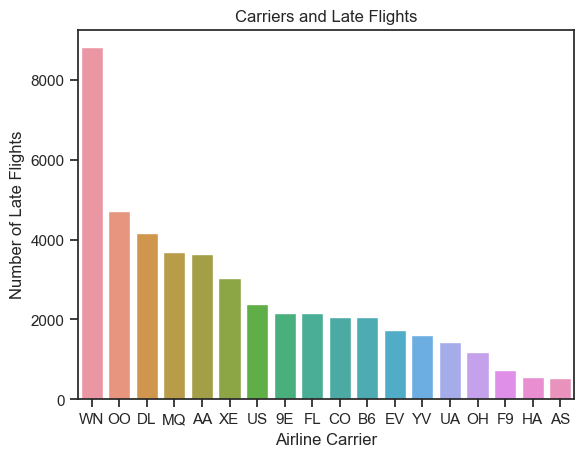

In [34]:
# Let's plot the values to see how the different carriers stack up.
plt.figure()
sns.barplot(data=late_flights,x=late_companies.index,y=late_companies.values)
plt.xlabel("Airline Carrier")
plt.ylabel("Number of Late Flights")
plt.title("Carriers and Late Flights")
plt.show()

# Now that we know which company has the most late flights.... 
# (Looking at you WN)

# Which company wastes the most time in total? On average? Has the highest median?

In [35]:
late_companies_time=late_flights.groupby("OP_CARRIER").agg({'ARR_DELAY':['sum','mean','std','median']})
print(late_companies_time.sort_values(by=('ARR_DELAY','sum'),ascending=False))
print(late_companies_time.sort_values(by=('ARR_DELAY','mean'),ascending=False))
print(late_companies_time.sort_values(by=('ARR_DELAY','median'),ascending=False))

           ARR_DELAY                             
                 sum       mean        std median
OP_CARRIER                                       
WN          221701.0  25.127621  27.523742   17.0
OO          143933.0  30.565513  41.282969   16.0
B6          116628.0  56.451113  61.156995   36.0
DL          115061.0  27.552921  45.240812   14.0
MQ          111350.0  30.258152  41.453015   17.0
AA           98062.0  26.858943  36.384290   15.0
XE           96584.0  31.718883  42.541405   16.0
US           70413.0  29.436873  39.668179   17.0
FL           68369.0  31.506452  48.193710   17.0
CO           67675.0  32.740687  61.367653   14.0
9E           66243.0  30.498619  43.506555   16.5
YV           54674.0  34.107299  47.910833   15.0
OH           53579.0  45.599149  57.120529   25.0
EV           51277.0  29.351460  44.249243   14.0
UA           51094.0  35.630404  72.832313   15.0
F9           20047.0  27.200814  39.990119   15.0
AS           13957.0  26.284369  44.198951   13.0


# While WN has the most total, both B6 and OH have the two highest on average and by median.

In [36]:
# Investigate our handy dandy dataframe
print(type(late_companies_time))
print(late_companies_time.columns)
print(late_companies_time.shape)

<class 'pandas.core.frame.DataFrame'>
MultiIndex([('ARR_DELAY',    'sum'),
            ('ARR_DELAY',   'mean'),
            ('ARR_DELAY',    'std'),
            ('ARR_DELAY', 'median')],
           )
(18, 4)


In [37]:
# Group the Late Companies Delays and calculate various numerical parameters such as median, mean, and sum.
late_companies_median=late_flights.groupby("OP_CARRIER").agg({'ARR_DELAY':'median'})
late_companies_mean=late_flights.groupby("OP_CARRIER").agg({'ARR_DELAY':'mean'})
late_companies_sum=late_flights.groupby("OP_CARRIER").agg({'ARR_DELAY':'sum'})

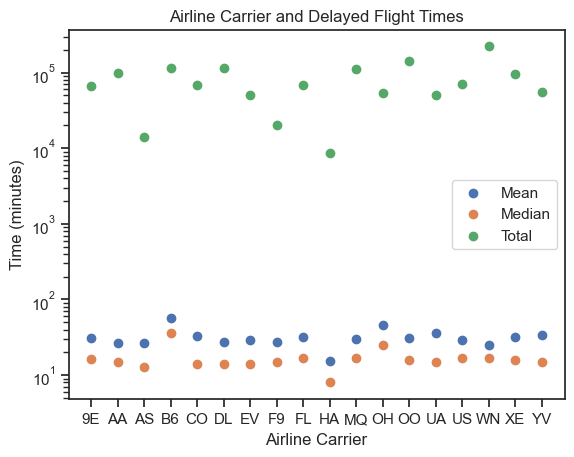

In [38]:
# Plot all the parameters on the same graph!
plt.figure()
plt.scatter(x=late_companies_mean.index, y=late_companies_mean.values,label="Mean")
plt.scatter(x=late_companies_median.index, y=late_companies_median.values, label="Median")
plt.scatter(x=late_companies_sum.index, y=late_companies_sum.values, label="Total")
plt.legend()
plt.yscale('log')
plt.title("Airline Carrier and Delayed Flight Times")
plt.xlabel("Airline Carrier")
plt.ylabel("Time (minutes)")
plt.show()

# Are the delays themselves related?

In [39]:
# Create a subset of the data using only the delays
df_delays=df_pd_small[['CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

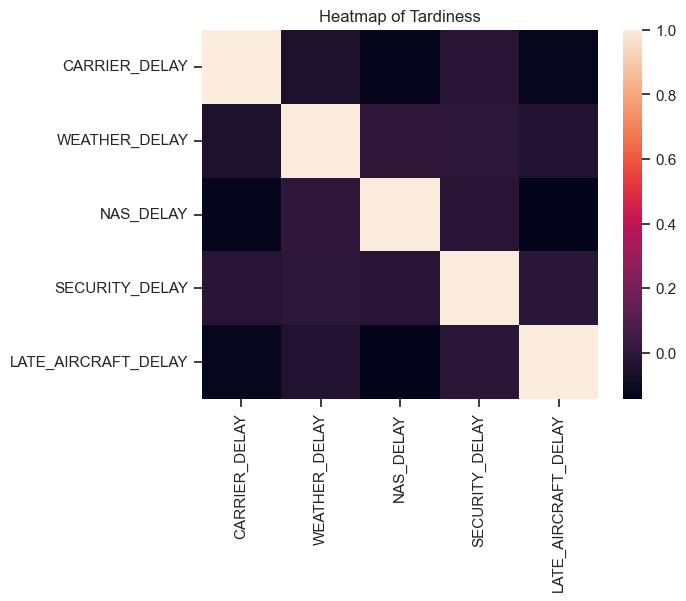

In [40]:
# Create a heatmap
plt.figure()
correlation=df_delays.corr()
sns.heatmap(correlation)
plt.title("Heatmap of Tardiness")
plt.show()

# The delays are not related.

# Results/Conclusion:
<a class="anchor" id="results_and_conclusions"></a>

* All airlines have late flights. However, some have significantly more than others. __About half of the airlines had median arrival times that were early, while the other half were late.__ 



* __Late aircraft delay was the most general cause of tardiness, followed by carrier delays and then NAS delays__. The late aircraft delays are hard to stop once in motion, as each successive flight after a tardy flight will be affected. However, the __carrier delays are easily fixable mistakes that could improve the productivity of an airline carrier__. The NAS (National Airspace Systems) delays are outside the control of the carrier and are unfortunately just part of the business. 



* __WN has the most late flights in total, while B6 and OH have the highest mean and median arrival times.__ 